## Train a model

### Get the data

In [ ]:
import numpy as np

import cv_model as cv
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
# get keras model
# the function preprocess_input is keras model dependent, so this is abstracted in a function so all the correct information can be produced at once
base_model, model_name, preprocess_input = cv.get_keras_model()

In [ ]:

# label mapping maps the numerically encoded label e.g. 1 back to the label e.g.'butter_naan'
mapping_dct = cv.get_label_mapping()

# get the fully split data that has been processed by the model specific preprocess_input function
X_train, y_train, X_test, y_test, X_val, y_val, label_encoder = cv.get_split_data(preprocess_input)

### Train the model

In [ ]:
# get number of classes to use as training target
num_classes = len(mapping_dct.values())

# the tasty_model uses transfer learning on the keras model and adds some layers for our use case
tasty_model = cv.get_tasty_model(base_model, num_classes)

# set the optimizer, learning rate, loss, and target metrics
tasty_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training params
batch_size = 32
epochs = 20
spe = len(X_train) // batch_size    
verbose = 1

# Augment the training data with a generaator.
# This improves performance with a small amount of data while reducing chance of overfitting due to the model not seeing the exact same image twice.
data_gen = ImageDataGenerator(rotation_range=30, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
flow = data_gen.flow(X_train, y_train, batch_size=batch_size)

# train
history = tasty_model.fit(flow, validation_data=(X_val, y_val), epochs=epochs, steps_per_epoch=spe, verbose=verbose)

# Evaluate model
val_loss, val_accuracy = tasty_model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

NameError: name 'mapping_dct' is not defined

: 

#### Visualize Training Progress

In [ ]:
def plot_history(history):
    # Plotting training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()    
    
plot_history(history)

#### Persist trained model

In [ ]:
#keras_model_path = 'models/efficientnet_v2_20_84.64.keras', 
#tflite_path='models/lite/efficientnet_v2_20_84.64.tflite', 
#weights_path = 'models/weights/efficientnet_v2_20_84.64.hdf5', 

# fake paths for testing...  delete before submitting
keras_model_path = 'models/efficientnet_v2_20_84.64_test.keras', 
tflite_path='models/lite/efficientnet_v2_20_84.64_test.tflite', 
weights_path = 'models/weights/efficientnet_v2_20_84.64_test.hdf5', 


Approach 1: Save whole model

In [ ]:
# save full keras model
tasty_model.save(keras_model_path)

Approach 2: Save weights

In [ ]:
# save model weights
tasty_model.save_weights(weights_path)

Approach 3: Convert to tflite and save that

In [ ]:
# prepare converter
converter = tf.lite.TFLiteConverter.from_keras_model(tasty_model) 

# life saving option found on stackoverflow
# https://stackoverflow.com/questions/69888228/converting-a-keras-model-to-tensorflow-lite-how-to-avoid-unsupported-operation
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# perform conversion
tflite_model = converter.convert()

# save
with open(tflite_path, 'wb') as f:     
  f.write(tflite_model)

## Results

This section is independent of training and evaluates results against persisted models.

In [1]:
import numpy as np

import cv_model as cv
import cv_predict as cvp

import keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# get keras model
# the function preprocess_input is keras model dependent, so this is abstracted in a function so all the correct information can be produced at once
preprocess_input = cv.get_keras_preprocessing()

In [3]:
# get data
X_train, y_train, X_test, y_test, X_val, y_val, label_encoder = cv.get_split_data(preprocess_input)

# get model
# we will only evalute against the tflite model as that's what we're going to use in the end
pred_model = cvp.TastyFoodPredictor(preprocess_input_fn=preprocess_input, use_keras=False, use_tflite=True)

Use **X_test** and **y_test** for model evaluation.  Since these datasets were not used during training, it should give us some insight into model generalizability.

In [ ]:
# get predictions
y_pred = pred_model.predict_batch(X_test)
y_true = y_test

In [19]:
# since this is a multi-class target, use np.argmax to get the top choice for each row
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

#### Confusion Matrix

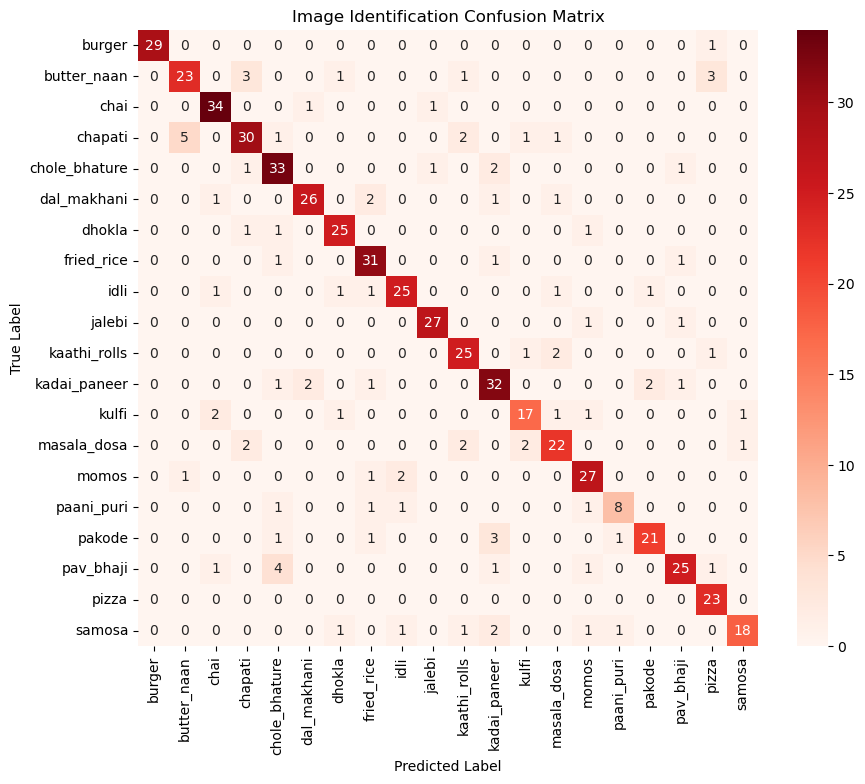

In [21]:
# convert to readible labels
labels = label_encoder.inverse_transform(range(0,20))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',  xticklabels=labels, yticklabels=labels)
plt.title('Image Identification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Precision and Recall

##### Class distribution

The barplot is an interesting place to start.  It would be interesting to combine the idea of how many examples there were, vs precision.

<Axes: >

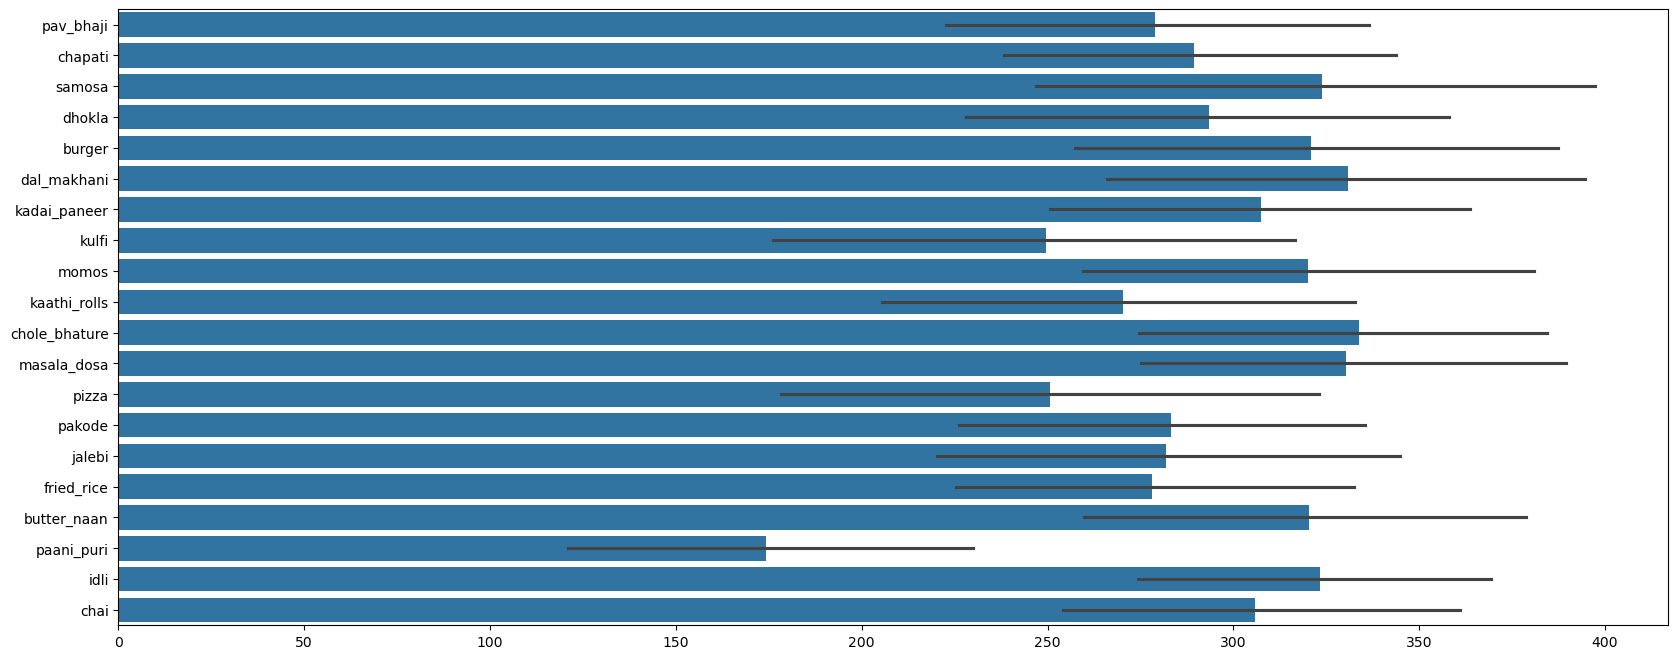

In [18]:
# convert to readible labels
y_true_classes = np.argmax(y_true, axis=1)
labels_freq = label_encoder.inverse_transform(y_true_classes)

plt.figure(figsize=(20, 8))
sns.barplot(labels_freq)

##### Macro Averaging

1/1 [==============================] - 4s 4s/step


##### Micro Averaging